## Vehicle Detection and Tracking

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier SVM classifier
* Also, applied a color transform and append binned color features, as well as histograms of color, to the HOG feature vector. 
* Normalized the features and randomize a selection for training and testing.
* Implement a sub sampling technique and used trained classifier to search for vehicles in images.
* Ran the pipeline on a video stream and created a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimated a bounding box for vehicles detected.

In [1]:
# Importing the libraries

import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy import misc
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
%matplotlib inline

In [3]:
#Importing few more libraries/functions
import collections
#Import the functions from functions1.py to be used in this notebook
from functions2 import *


In [4]:
# Fetching the dataset for vehicles and non vehicles ( all the images)

images = glob.glob('non-vehicles/**/*.png')
images2 = glob.glob('vehicles/**/*.png')
cars = []
notcars = []

for image in images:
    notcars.append(image)
    
for image in images2:
    cars.append(image)

### Displaying random images

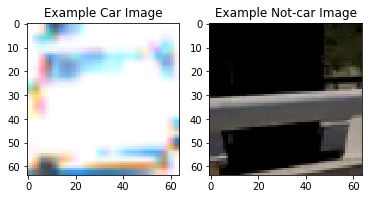

In [7]:
# Choosing random car / not-car indices and plotting example image
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


### Parameters 

Orientations = 11,
Pix_per_cell = 9,
cell_per_block = 2


In [5]:
# Parameters


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

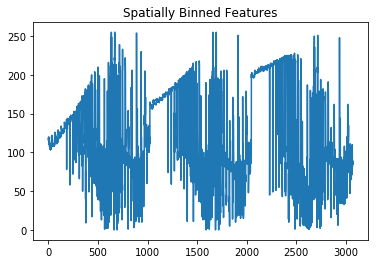

In [6]:
# To compute color historgram features

image = mpimg.imread('test_images/test4.jpg')
feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

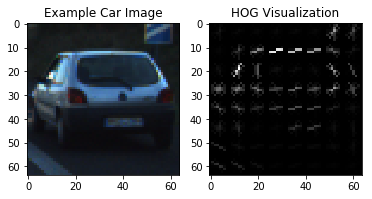

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

### Extract Features includes Histogram of Oriented Gradients (HOG)
I tried with different color space, started with RGB but it didnt work in this case. So, later I tried with YCrCb color space. Also explored the different parameters, tuned them to get better accuracy. Orientations as 9, 11, 13. Pixels per cell as 8, 16. 

I am reading all the images from vehicle and nonvehicle image datasets. Instead of extracting the HOG feature from each individual window, I am using sub sampling where it will extract HOG feature for the entire region of interest and then subsample that array. 



In [15]:
# Extracting the features (spatial color features, color histogram features and hog features)

t=time.time()

car_features = extract_features(cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

100%|██████████████████████████████████████████████████████████████████████████████| 8968/8968 [01:48<00:00, 82.66it/s]


224.83 Seconds to extract HOG features...


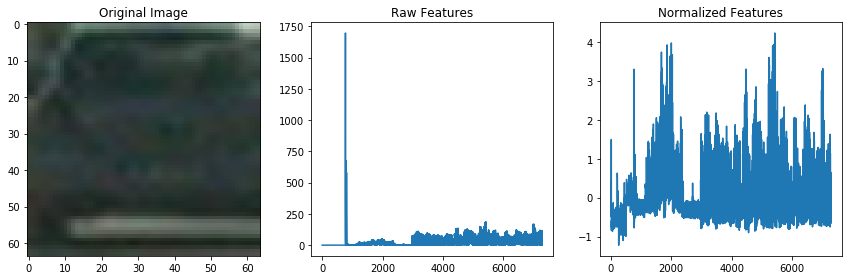

In [16]:
# Create array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

### Train the SVM Classifier 

I trained a SVM classifier with kernel as rbf and c value as 10 using the hog features, color features and spatial features. 
Previously I used Linear SVM but didnt got much accuracy, so later I used Grid Search to find the best parameters. It gave kernel as rbf and C as 10. 


In [17]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets with test size - 0.2 times the training data. 
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = svm.SVC(kernel='rbf', C=10)
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
1070.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
For these 10 labels:  [1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
0.30221 Seconds to predict 10 labels with SVC


Total length of feature vector : 7284
Time Taken : 1070.15 


In [19]:
# Dumping the model in the pickle file (to later use the same and no need to train it again)
joblib.dump(svc, 'svc1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')

['scaler1.pkl']

#### Loading the Trained model from the pickle file

In [6]:
svc = joblib.load('svc.pkl')
X_scaler = joblib.load('scaler.pkl')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator SVC from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Plotting the example images with bounding boxes and heat map

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  


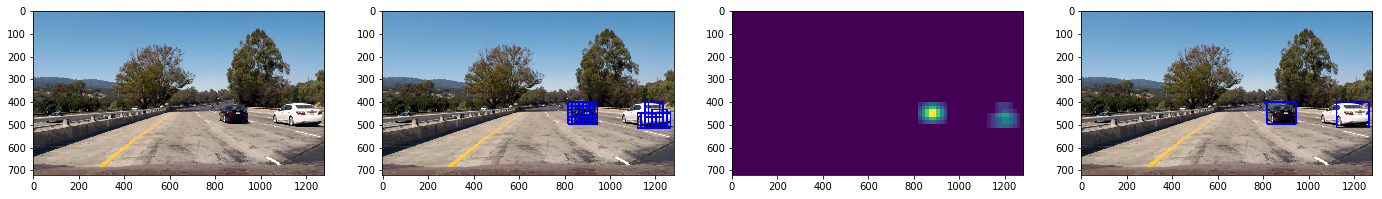

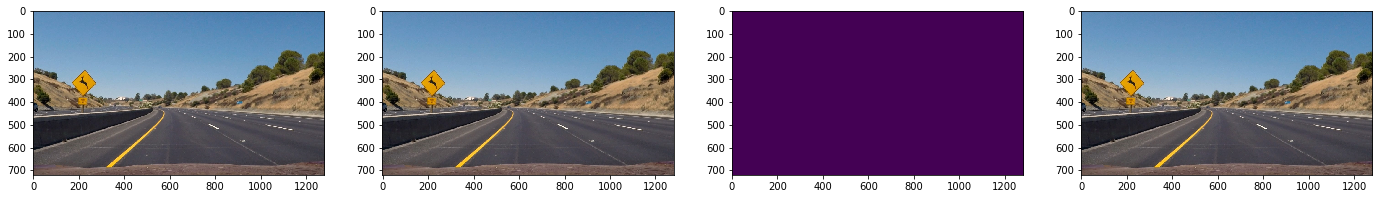

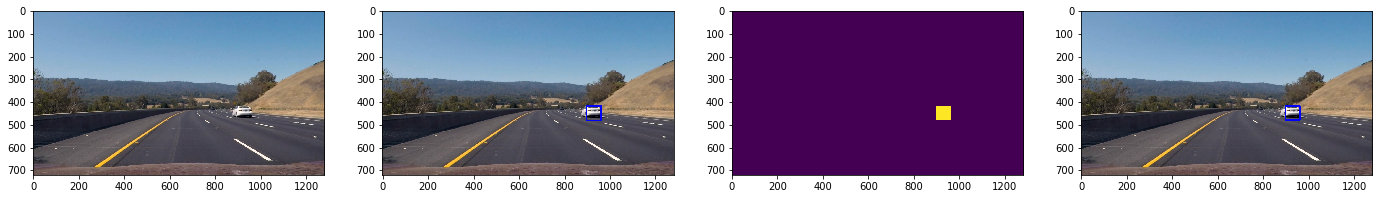

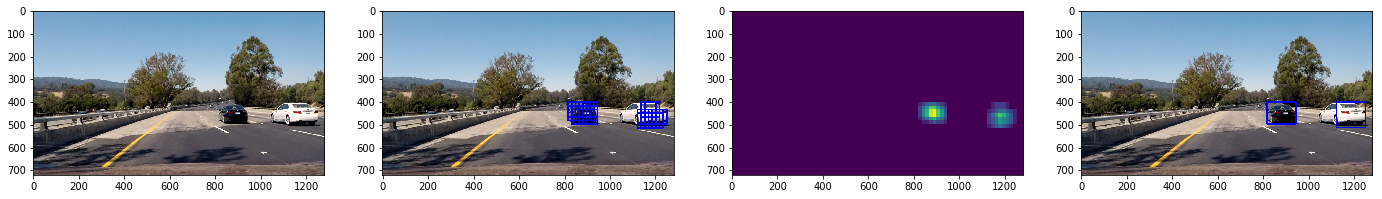

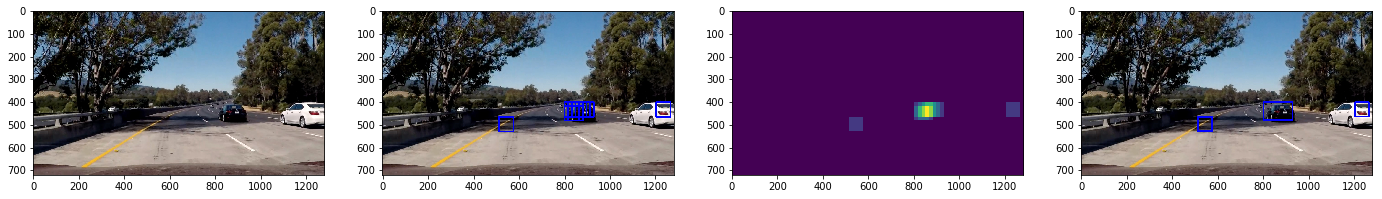

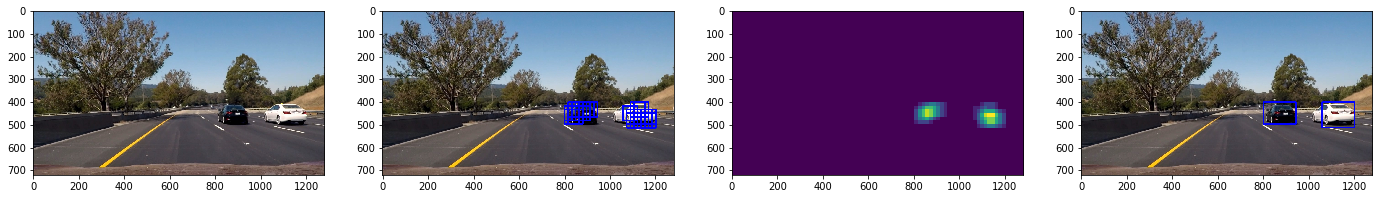

In [31]:
test_images = glob.glob('test_images/*.jpg')
ystart = 400
ystop = 656
scale = 1.0
for img in test_images:
    image = mpimg.imread(img)
    boxes = find_cars(image, ystart, ystop , scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img = draw_boxes(image, boxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)
    #heat = apply_threshold(heatmap_sum,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plt.figure()
    
    # Plot the examples
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    ax1.imshow(image)
    ax2.imshow(out_img)
    ax3.imshow(heatmap)
    ax4.imshow(draw_img)


### Pipeline to process image and Video 

I am using Hog Subsampling as its better way to fetch the hog featues. First, I used one region of interest and scale, but later to improve the detection process I added more region of interests which separate scale. 

In [20]:
def pipeline(image):
    '''boxes_list = find_cars(image,ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)'''
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    #heatmap_avg = heatmap_sum/10
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heatmap_sum,4)
    bboxes1 =[]

    ystart = 400
    ystop = 560
    scale = 1.5
    box_list2 = find_cars(image, ystart, ystop , scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 472
    ystop = 560
    scale = 2
    box_list3 = find_cars(image, ystart, ystop , scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    ystart = 496
    ystop = 656
    scale = 2.5
    box_list4 = find_cars(image, ystart, ystop , scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    bboxes1.extend(box_list2)    
    bboxes1.extend(box_list3)    
    bboxes1.extend(box_list4)     

    current_heatmap = add_heat(heat,bboxes1)
    heatmaps.append(current_heatmap)
    heatmap_sum = np.array(heatmaps).sum(axis=0)
    
    heat = apply_threshold(heatmap_sum,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap_sum, 0, 255)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

#### Process the Image to detect the cars

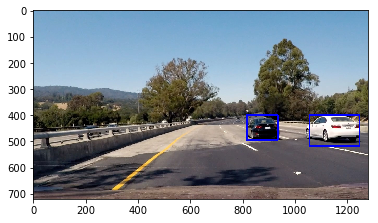

In [16]:
image = mpimg.imread('test_images/test4.jpg')
heatmaps = collections.deque(maxlen=5)  # Deque to keep last 5 frames in memory 
img= pipeline(image)

plt.imshow(img)


### Process the video to detect and track vehicles

First, I found the false positive in few frames of the video. So, to remove the false positive we are creating the heatmap and the threshold to remove the false positives. Then I am keeping the last 10 frames of history and summed up the heat to make the traking smoother and detection more easier.

In [21]:
# Import Libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Initializing heatmaps to keep last 10 frames in memory. 
heatmaps = collections.deque(maxlen=10)
write_output = 'project_video_out.mp4' # Output Image
clip1 = VideoFileClip("project_video.mp4")#.subclip(15,20)
write_clip = clip1.fl_image(pipeline)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [38:39<00:01,  1.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 39min 13s, sys: 22.2 s, total: 39min 36s
Wall time: 38min 39s


Video is saved with name "project_video_out.mp4"

### Discussion
1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

    I started with only extracting the HOG features and training the classifier on the same. But later I included color and spatial features and combined all the features so that to improve the classification. Then I choose SVM classifier, first was trying with Linear but was not getting desired accuracy, so I used Grid Search to find the best parameter combinations from the given values. Based on the output, I chose rbg kernel and c value as 10. 

    Now, I was able to achieve good accuracy. I used the model to detect the car on the test images, where i could see few false positives and also car image which is far and small in size not getting detected. Later I added multiple scales and accordingly different window sizes for the same such that it will detect the white car. 

    For future work, I can use deep learning approach for this, as this includes lots of parameter tuning which will reduce in the deep learning case. Through that, we might able to achieve better detection and tracking of the vehicle with minimal false positives.